# Support Vector Machines

In [1]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from time import time
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

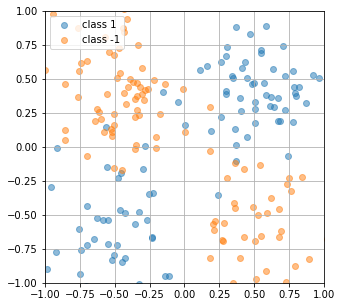

In [2]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
dataset = datasets['dataset_3']

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax)

## III- Kernel SVC 
### 1- Implementing the Gaussian and linear kernels

Implement the method 'kernel' of the classes RBF and Linear below. The RBF kernel which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [3]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        X2 = (X**2).sum(axis=-1) # size N
        Y2 = (Y**2).sum(axis=-1) # size M
        XdotY = X.dot(Y.T)
        diff2 = X2[:,None] + Y2[None,:] - 2*XdotY
        return np.exp(-diff2/(2*self.sigma**2))    ## Matrix of shape NxM

In [4]:
class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return X.dot(Y.T)

### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

### Question 1

a) The Lagrangian writes : 

$$ L(f, b, \xi, \alpha, \mu) = \frac{1}{2}f^TKf + C \xi^T\textbf{1 } - \xi^T(\alpha + \mu) +\alpha^T\textbf{1 } - b\alpha^Ty - (\text{diag}(y)\alpha )^TKf$$

b) We get the dual problem by taking the infimum on $(f, b, \xi)$ :

 $$ \underset{\alpha \in \mathbb{R}^n}{\text{max }} \alpha^T\textbf{1 } - \frac{1}{2}(\text{diag}(y)\alpha)^TK(\text{diag}(y)\alpha)$$
 
with constraints : $$ 0 \leqslant \alpha_i \leqslant C, \alpha^Ty = 0$$

We can express $f(x)$ in function of $\alpha$ : $$ f(x) = \sum_{i=1}^n{y_i\alpha_i K(x, x_i)}$$

c) With strong duality we get 

\begin{equation*}
\begin{cases}
\alpha_i (1 - x_i - y_i(f(x_i) + b)) = 0 \\
(C - \alpha_i)\xi_i = 0
\end{cases}
\end{equation*}

It implies that $$ 0 < \alpha_i < C \Longleftrightarrow y_i(f(x_i) + b) = 1$$

In [5]:
import cvxpy as cp

In [6]:
class KernelSVC:
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        self.X = X
        self.y = y
        K = self.kernel(X, X)
        N = len(y)

        # alpha = cp.Variable(N)
        # objective = cp.Minimize(-cp.sum(alpha) + (1/2)*cp.quad_form(cp.multiply(y,alpha), K) )
        # constraints = [
        #     alpha @ y == 0,  # alpha^T y = 0
        #     alpha >= 0,      # alpha >= 0
        #     alpha <= self.C      # alpha <= C
        # ]


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        
        # problem = cp.Problem(objective, constraints)
        # problem.solve()

        # self.alpha = alpha.value

        Lagrange dual problem
        def loss(alpha):
            return  -np.sum(alpha) + (y*alpha).T@K@(y*alpha) / 2

        # Partial derivate of Lagrange dual on alpha
        def grad_loss(alpha):
            return -np.ones_like(N) + np.diag(y)@K@(y*alpha)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: alpha@y  # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:  y  #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha: np.concatenate((alpha, self.C-alpha))  # '''---------------function defining the inequality constraint-------------------'''     
        I = np.zeros((2*N, N))
        I[:N,:] = np.eye(N)
        I[N:,:] = -np.eye(N)
        jac_ineq = lambda alpha: I  # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})
        

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes

        self.support = self.X[(self.epsilon<self.alpha) & (self.alpha < self.C)]
        fx = (self.alpha[:,None]*y[:,None]*K).sum(axis=-1)
        
        self.b = np.mean(y[(self.epsilon<self.alpha) & (self.alpha < self.C)] \
                        - fx[(self.epsilon<self.alpha) & (self.alpha < self.C)]) #''' -----------------offset of the classifier------------------ '''
        self.norm_f = np.sum(((y*self.alpha)@K@(y*self.alpha)) **2) # '''------------------------RKHS norm of the function f ------------------------------'''
        
        self.y = y[(self.epsilon<self.alpha) & (self.alpha < self.C)]
        self.alpha = self.alpha[(self.epsilon<self.alpha) & (self.alpha < self.C)]
        

    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        similarity_matrix = self.kernel(x, self.support)
        separating_fun = (similarity_matrix*self.y[None,:]*self.alpha[None,:]).sum(axis=-1)
        return separating_fun
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 3- Fitting the classifier

Run the code block below to fit the classifier and report its output.

### Dataset 1
#### Linear classifier

In [7]:
C = 0.5 #TODO: provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']

In [8]:
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm([-1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.
  1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.
  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1.  1.  1.  1. -1.  1.] @ var1, [[0.97 0.44 ... 1.09 -0.39]
 [0.44 0.23 ... 0.47 -0.18]
 ...
 [1.09 0.47 ... 1.23 -0.44]
 [-0.39 -0.18 ... -0.44 0.16]])

#### Gaussian classifier

Number of support vectors = 15


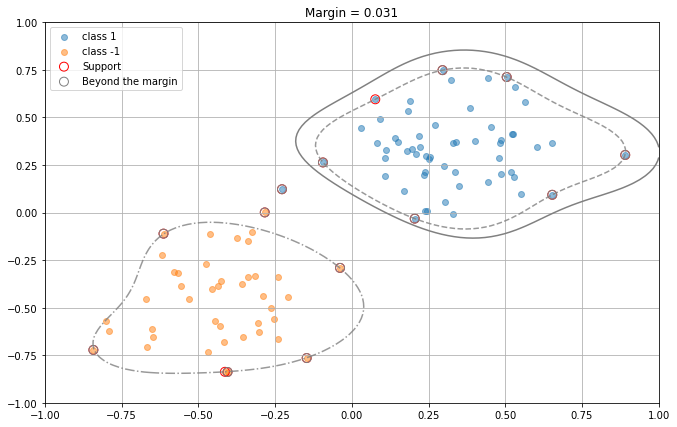

In [8]:
sigma = 0.3#TODO: provide a reasonalbe value
C = 2 #TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 2
#### Linear SVM

Number of support vectors = 28


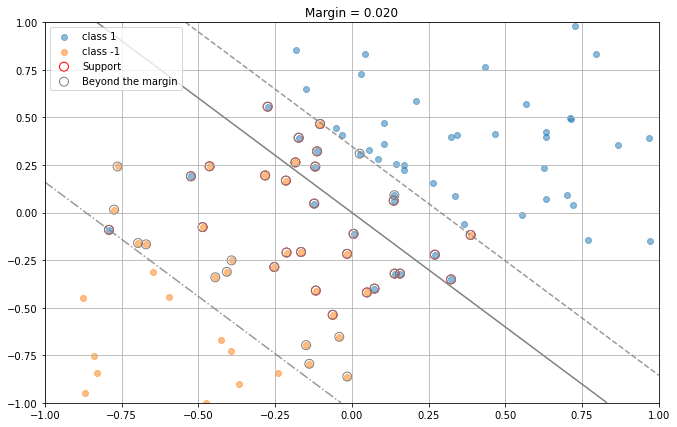

In [9]:
C = 3 #TODO: provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-11)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

Number of support vectors = 34


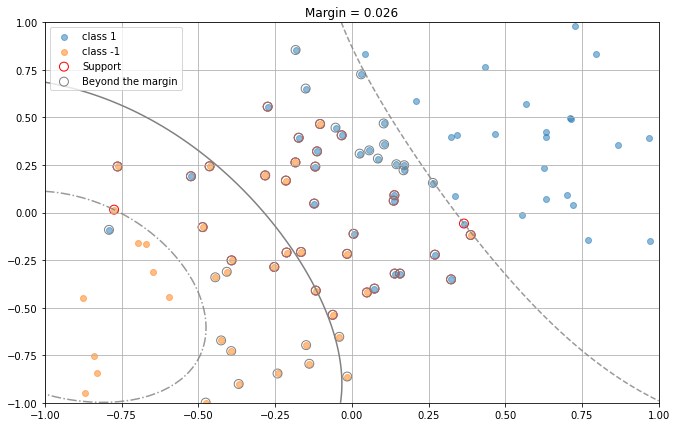

In [10]:
sigma = 1 #TODO: provide a reasonalbe value
C = 1 #TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 3
#### Linear SVM

In [13]:
C = 1 #TODO: provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

KeyError: 'dataset_3'

#### Gaussian SVM

In [14]:
sigma = 0.6 #TODO: provide a reasonalbe value
C = 1.5 #TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

KeyError: 'dataset_3'

# Kernel Regression

## Loading the data

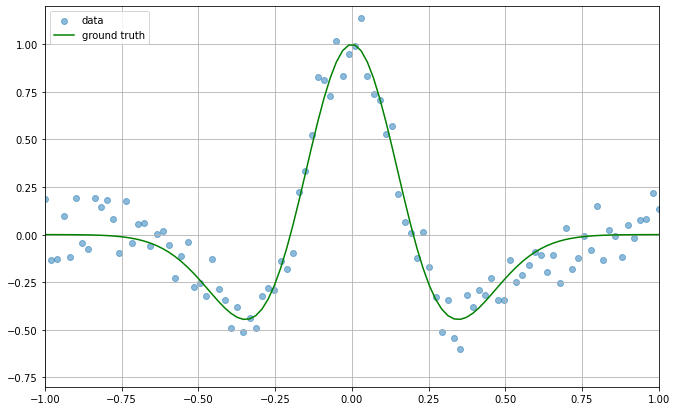

In [15]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])

### Question 2

According to the representer theorem, the regression function $f$ can be expressed as  

$$ f(x) = \sum_{i=1}^N{\alpha_i K(x, x_i)} + b$$ 

with $\alpha \in \mathbb{R}^N$ and $b\in \mathbb{R}$


The optimization problem can be rewritten as 

$$ \underset{\alpha, b}{\text{min }} \frac{1}{N}\|K\alpha - y + b\textbf{1}\|_2^2 +\frac{\lambda}{2}\alpha^T K \alpha$$

Let $K$ be the Gram matrix of $(x_i)_{1\leq i \leq N}$. 

Then, let $A$ be the square matrix of size $N+1$ with $K$ in the top left corner and zero entries otherwise.

Let $B$ the matrix $K$ with an additional column of ones.

Then the solution of the problem is $(\alpha^*, b^*)^T = (B^TB + \frac{N\lambda}{2} A)^{-1} B^Ty $

For the multivariate case, we can express $f$ as $f(x) = (f_1(x), \cdots, f_q(x))$ where 

$$ f_j(x) = \sum_{i=1}^N{\alpha_{j, i} K(x, x_i)} $$

## Kernel Ridge Regression
### 1- Implementing the regressor
Implement the method `fit` of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 

In [16]:
class KernelRR:
    
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel    
        self.alpha = None 
        self.b = None
        self.support = None
        self.type='ridge'
        
    def fit(self, X, y):
        N = len(y)
        K = self.kernel(X, X)
        A = np.zeros((N+1, N+1))
        A[:N,:N] = K
        B = np.zeros((N, N+1))
        B[:,:N] = K
        B[:,-1] = 1
        self.support = X
        theta = np.linalg.solve(B.T@B + self.lmbda*N / 2 * A, B.T@y)
        self.b = theta[-1]
        self.alpha = theta[:-1]    
        
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        similarity_matrix = kernel(x, self.support)
        regression = similarity_matrix.dot(self.alpha) 
        return regression

    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+self.b

    
class MultivariateKernelRR:      
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type='ridge'
    
    def fit(self, X, y):
        N, q = y.shape
        self.support = X
        K = self.kernel(X, X)
        self.b = np.zeros(q)
        self.alpha = np.zeros((q, N))
        A = np.zeros((N+1, N+1))
        A[:N,:N] = K
        B = np.zeros((N, N+1))
        B[:,:N] = K
        B[:,-1] = 1
        theta = np.linalg.solve(B.T@B + self.lmbda*N / 2 * A, B.T@y)
        self.b = theta[-1,:]
        self.alpha = theta[:-1,:] 
        
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        q = len(self.b)
        n, d = x.shape
        similarity_matrix = kernel(x, self.support)
        outputs = similarity_matrix.dot(self.alpha)            
        return outputs
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+np.expand_dims(self.b,axis=0) 

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

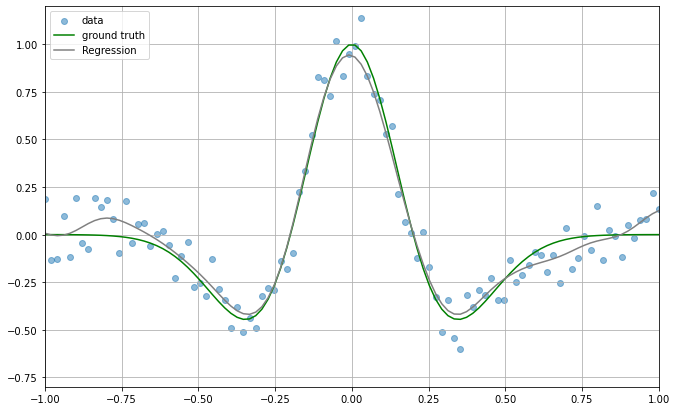

In [17]:
sigma = 0.1 #TODO: provide a reasonable value
lmbda= 1e-2 #TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelRR(kernel, lmbda=lmbda)
model.fit(train_set['x'].reshape(-1,1),train_set['y'])
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

# Kernel PCA

### 1- Implementing kernel PCA
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 

###  Center the Gram matrix

$$ \widetilde{K}_{i, j} = K(x_i, x_j) - \frac{1}{n}\sum_{l=1}^n{K(x_i, x_l)} - \frac{1}{n}\sum_{l=1}^n{K(x_j, x_l)} + \frac{1}{n^2}\sum_{l,p}{K(x_l, x_p)}$$

### Representation of a new point $x$

\begin{aligned}
\widetilde{K}(x, x_i) &= \left\langle \varphi(x) - \frac{1}{n}\sum_{i=1}^n{\varphi(x_i)}, \varphi(x_j) - \frac{1}{n}\sum_{i=1}^n{\varphi(x_i)} \right\rangle  \\
&= \langle \varphi(x), \varphi(x_i)\rangle -  \frac{1}{n}\sum_{i=1}^n{\langle \varphi(x), \varphi(x_i) \rangle} - \frac{1}{n}\sum_{i=1}^n{\langle \varphi(x_j), \varphi(x_i) \rangle} + \frac{1}{n^2}\sum_{i,j}{\langle \varphi(x_i), \varphi(x_j) \rangle} \\
&= K(x, x_i) -  \frac{1}{n}\sum_{i=1}^n{K(x, x_i)} - \frac{1}{n}\sum_{i=1}^n{K(x_j, x_i)} + \frac{1}{n^2}\sum_{i,j}{K(x_i, x_j)}
\end{aligned}

Then, the representation of $x$ is : 

$$ (\widetilde{K}(x, x_i))_{1\leqslant i \leqslant n}  \alpha $$

where $\alpha$ is the matrix of  rescaled eigenvectors of the Gram matrix.

In [18]:
class KernelPCA:
    
    def __init__(self,kernel, r=2):                             
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
    def compute_PCA(self, X):
        # assigns the vectors
        self.support = X
        N = X.shape[0]
        K = self.kernel(X, X)
        G = K - K.mean(axis=-1)[:,None] - K.mean(axis=-1)[None,:] + K.mean()  # Center the kernel matrix
        
        self.G = G
        eigvalues, eigvectors = np.linalg.eigh(self.G)
        eigvalues = eigvalues[::-1]
        eigvectors = eigvectors[:,::-1]
        self.lmbda = eigvalues[:self.r]
        self.alpha = eigvectors[:,:self.r]/np.sqrt(self.lmbda)[None,:]
        
    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        N, d = x.shape  
        n = self.support.shape[0]
        ones = np.ones((n, n)) / n
        K = self.kernel(self.support, self.support)
        G = self.kernel(x, self.support) # N x n
        output = np.zeros((N, self.r))
        G = G  - G.mean(axis=-1)[:,None] - K.mean(axis=-1)[None,:] + K.mean()
            
        output = G.dot(self.alpha)
        
        return output

### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

100
100


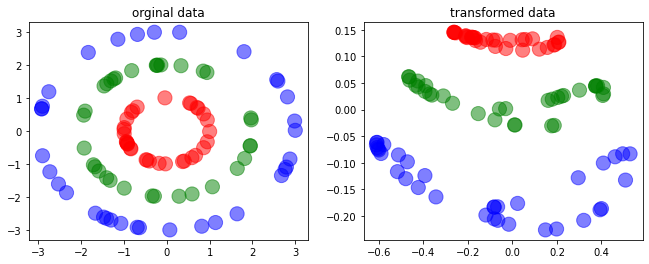

In [19]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']
print(len(train_set["x"]))
print(len(test_set["x"]))

sigma = 4
kernel = RBF(sigma).kernel
pca = KernelPCA(
    kernel, r=3)
pca.compute_PCA(train_set['x'])
pca_components = pca.transform(test_set['x'])

indices = [1, 2]
pca_components = pca_components[:,indices] 

fig, ax = plt.subplots(1,2, figsize=(11, 4))
scatter_label_points(test_set['x'], test_set['y'], ax[0], title='orginal data')
scatter_label_points(pca_components,test_set['y'], ax[1], title= 'transformed data')

# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

In [20]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder,dim_pca, lmbda):
        self.pca = KernelPCA(kernel_encoder, r=dim_pca)
        self.ridge_reg = MultivariateKernelRR(kernel_decoder, lmbda=lmbda)
    
    def fit(self,train):
        self.pca.compute_PCA(train)
        encoding = self.pca.transform(train)
        self.ridge_reg.fit(encoding, train)
        
    def denoise(self,test):
        n, d = test.shape
        encoding = self.pca.transform(test)
        denoised_data = self.ridge_reg.predict(encoding)
        return denoised_data.reshape(n, int(np.sqrt(d)), int(np.sqrt(d)))

### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extend the denoising is successful? How can it be improved?

In [21]:
start = time()
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']

dim_pca = 80 #400 # 10, 30, 60, 70
lmbda = 1e-3/2 #/ 2 # 1
sigma_encoder = 10 # 8
sigma_decoder = 10 # 1
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)
denoiser.fit(data['train'].reshape(2000, 28*28))
end = time()
print("Running time : {:.2f}".format((end-start)/60))

Running time : 0.03


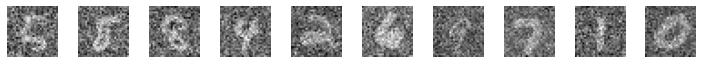

In [22]:
plot_multiple_images(data['train'])


In [29]:
pred = denoiser.denoise(data['test'].reshape(2000, 28*28))

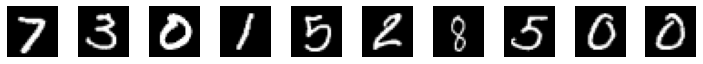

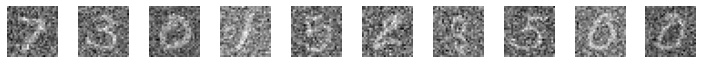

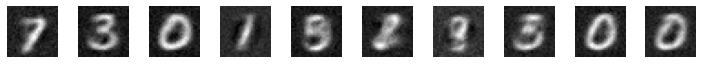

In [30]:
plot_multiple_images(clean_data['test'])
plot_multiple_images(data['test'])
plot_multiple_images(pred)